# Predicting Telco Customer Churn using SparkML on IBM Cloud Pak for Data (ICP4D)

We'll use this notebook to create a machine learning model to predict customer churn. In this notebook we will build the prediction model using the SparkML library.

This notebook walks you through these steps:

- Load and Visualize data set.
- Build a predictive model with SparkML API
- Save the model in the ML repository

## 1.0 Install required packages

There are a couple of Python packages we will use in this notebook. First we make sure the Watson Machine Learning client v3 is removed (its not installed by default) and then install/upgrade the v4 version of the client (this package is installed by default on CP4D).

WML Client: https://wml-api-pyclient-dev-v4.mybluemix.net/#repository

In [ ]:
!pip uninstall watson-machine-learning-client -y
!pip install --user watson-machine-learning-client-v4 --upgrade | tail -n 1
!pip install --user pyspark==2.3.3 --upgrade|tail -n 1

In [37]:
import pandas as pd
import numpy as np
import json
import os

# Import the Project Library to read/write project assets
from project_lib import Project
project = Project.access()

import warnings
warnings.filterwarnings("ignore")

## 2.0 Load and Clean data

We'll load our data as a pandas data frame.

**<font color='red'><< FOLLOW THE INSTRUCTIONS BELOW TO LOAD THE DATASET >></font>**

* Highlight the cell below by clicking it.
* Click the `10/01` "Find data" icon in the upper right of the notebook.
* If you are using Virtualized data, begin by choosing the `Files` tab. Then choose your virtualized data (i.e. MYSCHEMA.BILLINGPRODUCTCUSTOMERS), click `Insert to code` and choose `Insert Pandas DataFrame`.
* If you are using this notebook without virtualized data, add the locally uploaded file `Telco-Customer-Churn.csv` by choosing the `Files` tab. Then choose the `Telco-Customer-Churn.csv`. Click `Insert to code` and choose `Insert Pandas DataFrame`.
* The code to bring the data into the notebook environment and create a Pandas DataFrame will be added to the cell below.
* Run the cell


In [38]:
# Place cursor below and insert the Pandas DataFrame for the Telco churn data



,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,...,Churn,gender,SeniorCitizen,Partner,Dependents,tenure,NATIONAL_ID,CREDITCARD_NUMBER,CREDITCARD_TYPE,CREDITCARD_EXP
0,No,No phone service,DSL,Yes,Yes,No,No,No,No,Month-to-month,...,No,Female,1,No,No,43,730-57-4435,6011470000003320,Discover,20-Oct
1,Yes,No,Fiber optic,Yes,No,No,No,Yes,Yes,Month-to-month,...,No,Female,0,No,No,24,317-42-6092,6011120000001890,Discover,18-Jun
2,Yes,No,Fiber optic,Yes,No,Yes,Yes,Yes,Yes,Two year,...,No,Male,0,No,No,66,444-56-2555,370000024623318,American Express,22-Mar
3,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,...,No,Male,1,No,No,26,329-64-4927,6011010000002280,Discover,19-Apr
4,Yes,No,Fiber optic,No,No,Yes,No,No,Yes,Month-to-month,...,Yes,Female,0,No,No,6,596-87-7974,4111500000003080,VISA,23-Oct


We'll use the Pandas naming convention df for our DataFrame. Make sure that the cell below uses the name for the dataframe used above. For the locally uploaded file it should look like df_data_1 or df_data_2 or df_data_x. For the virtualized data case it should look like data_df_1 or data_df_2 or data_df_x.

**<font color='red'><< UPDATE THE VARIABLE ASSIGNMENT TO THE VARIABLE GENERATED ABOVE. >></font>**

In [39]:
# for virtualized data
df = df_data_1

# for local upload
# df = data_df_3

### 2.1 Drop CustomerID feature (column)

In [40]:
# df = df.drop('customerID', axis=1)
# df.head(5)

### 2.2 Examine the data types of the features

In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7032 entries, 0 to 7031
Data columns (total 24 columns):
PhoneService         7032 non-null object
MultipleLines        7032 non-null object
InternetService      7032 non-null object
OnlineSecurity       7032 non-null object
OnlineBackup         7032 non-null object
DeviceProtection     7032 non-null object
TechSupport          7032 non-null object
StreamingTV          7032 non-null object
StreamingMovies      7032 non-null object
Contract             7032 non-null object
PaperlessBilling     7032 non-null object
PaymentMethod        7032 non-null object
MonthlyCharges       7032 non-null float64
TotalCharges         7032 non-null float64
Churn                7032 non-null object
gender               7032 non-null object
SeniorCitizen        7032 non-null int64
Partner              7032 non-null object
Dependents           7032 non-null object
tenure               7032 non-null int64
NATIONAL_ID          7032 non-null object
CREDITCARD_

In [42]:
# Statistics for the columns (features). Set it to all, since default is to describe just the numeric features.
df.describe(include = 'all')

,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,...,Churn,gender,SeniorCitizen,Partner,Dependents,tenure,NATIONAL_ID,CREDITCARD_NUMBER,CREDITCARD_TYPE,CREDITCARD_EXP
count,7032,7032,7032,7032,7032,7032,7032,7032,7032,7032,...,7032,7032,7032.000000,7032,7032,7032.000000,7032,7.032000e+03,7032,7032
unique,2,3,3,3,3,3,3,3,3,3,...,2,2,NaN,2,2,NaN,328,NaN,6,60
top,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,...,No,Male,NaN,No,No,NaN,642-64-0569,NaN,American Express,20-Apr
freq,6352,3385,3096,3497,3087,3094,3472,2809,2781,3875,...,5163,3549,NaN,3639,4933,NaN,22,NaN,1543,195
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.162400,NaN,NaN,32.421786,NaN,2.848948e+15,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.368844,NaN,NaN,24.545260,NaN,2.252976e+15,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.000000,NaN,NaN,1.000000,NaN,3.000000e+13,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.000000,NaN,NaN,9.000000,NaN,3.700000e+14,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.000000,NaN,NaN,29.000000,NaN,3.088610e+15,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.000000,NaN,NaN,55.000000,NaN,4.111870e+15,NaN,NaN


We see that Tenure ranges from 0 (new customer) to 6 years, Monthly charges range from $18 to $118, etc

### 2.3 Check for need to Convert TotalCharges column to numeric if it is detected as object

If the above `df.info` shows the "TotalCharges" columnn as an object, we'll need to convert it to numeric. If you have already done this during a previous exercise for "Data Visualization with Data Refinery", you can skip to step `2.4`.

In [43]:
totalCharges = df.columns.get_loc("TotalCharges")
new_col = pd.to_numeric(df.iloc[:, totalCharges], errors='coerce')
df.iloc[:, totalCharges] = pd.Series(new_col)

In [44]:
# Statistics for the columns (features). Set it to all, since default is to describe just the numeric features.
df.describe(include = 'all')

,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,...,Churn,gender,SeniorCitizen,Partner,Dependents,tenure,NATIONAL_ID,CREDITCARD_NUMBER,CREDITCARD_TYPE,CREDITCARD_EXP
count,7032,7032,7032,7032,7032,7032,7032,7032,7032,7032,...,7032,7032,7032.000000,7032,7032,7032.000000,7032,7.032000e+03,7032,7032
unique,2,3,3,3,3,3,3,3,3,3,...,2,2,NaN,2,2,NaN,328,NaN,6,60
top,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,...,No,Male,NaN,No,No,NaN,642-64-0569,NaN,American Express,20-Apr
freq,6352,3385,3096,3497,3087,3094,3472,2809,2781,3875,...,5163,3549,NaN,3639,4933,NaN,22,NaN,1543,195
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.162400,NaN,NaN,32.421786,NaN,2.848948e+15,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.368844,NaN,NaN,24.545260,NaN,2.252976e+15,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.000000,NaN,NaN,1.000000,NaN,3.000000e+13,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.000000,NaN,NaN,9.000000,NaN,3.700000e+14,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.000000,NaN,NaN,29.000000,NaN,3.088610e+15,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.000000,NaN,NaN,55.000000,NaN,4.111870e+15,NaN,NaN


We now see statistics for the `TotalCharges` feature.



### 2.4 Any NaN values should be removed to create a more accurate model.

In [45]:
# Check if we have any NaN values and see which features have missing values that should be addressed
print(df.isnull().values.any())
df.isnull().sum()

False


PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges         0
Churn                0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
NATIONAL_ID          0
CREDITCARD_NUMBER    0
CREDITCARD_TYPE      0
CREDITCARD_EXP       0
dtype: int64

We should see that the `TotalCharges` column has missing values. There are various ways we can address this issue:

- Drop records with missing values 
- Fill in the missing value with one of the following strategies: Zero, Mean of the values for the column, Random value, etc).

In [46]:
# Handle missing values for nan_column (TotalCharges)
from sklearn.impute import SimpleImputer

# Find the column number for TotalCharges (starting at 0).
total_charges_idx = df.columns.get_loc("TotalCharges")
imputer = SimpleImputer(strategy="most_frequent") #SimpleImputer(strategy="most_frequent")

df.iloc[:, total_charges_idx] = imputer.fit_transform(df.iloc[:, total_charges_idx].values.reshape(-1, 1))
df.iloc[:, total_charges_idx] = pd.Series(df.iloc[:, total_charges_idx])

In [47]:
# Validate that we have addressed any NaN values
print(df.isnull().values.any())
df.isnull().sum()

False


PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges         0
Churn                0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
NATIONAL_ID          0
CREDITCARD_NUMBER    0
CREDITCARD_TYPE      0
CREDITCARD_EXP       0
dtype: int64


### 2.5 Categorize Features

We will categorize some of the columns / features based on wether they are categorical values or continuous (i.e numerical) values. We will use this in later sections to build visualizations.

In [48]:
columns_idx = np.s_[0:] # Slice of first row(header) with all columns.
first_record_idx = np.s_[0] # Index of first record

string_fields = [type(fld) is str for fld in df.iloc[first_record_idx, columns_idx]] # All string fields
all_features = [x for x in df.columns if x != 'Churn']
categorical_columns = list(np.array(df.columns)[columns_idx][string_fields])
categorical_features = [x for x in categorical_columns if x != 'Churn']
continuous_features = [x for x in all_features if x not in categorical_features]

#print('All Features: ', all_features)
#print('\nCategorical Features: ', categorical_features)
#print('\nContinuous Features: ', continuous_features)
#print('\nAll Categorical Columns: ', categorical_columns)

### 2.6 Visualize data

Data visualization can be used to find patterns, detect outliers, understand distribution and more. We can use graphs such as:

- Histograms, boxplots, etc: To find distribution / spread of our continuous variables.
- Bar charts: To show frequency in categorical values.


In [49]:
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder

%matplotlib inline
sns.set(style="darkgrid")
sns.set_palette("hls", 3)

First, we get a high level view of the distribution of `Churn`. What percentage of customer in our dataset are churning vs not churning. 

Churn
No     5163
Yes    1869
dtype: int64


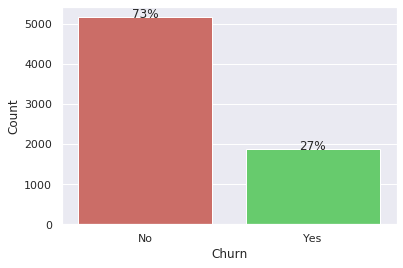

In [50]:
print(df.groupby(['Churn']).size())
churn_plot = sns.countplot(data=df, x='Churn', order=df.Churn.value_counts().index)
plt.ylabel('Count')
for p in churn_plot.patches:
    height = p.get_height()
    churn_plot.text(p.get_x()+p.get_width()/2., height + 1,'{0:.0%}'.format(height/float(len(df))),ha="center") 
plt.show()

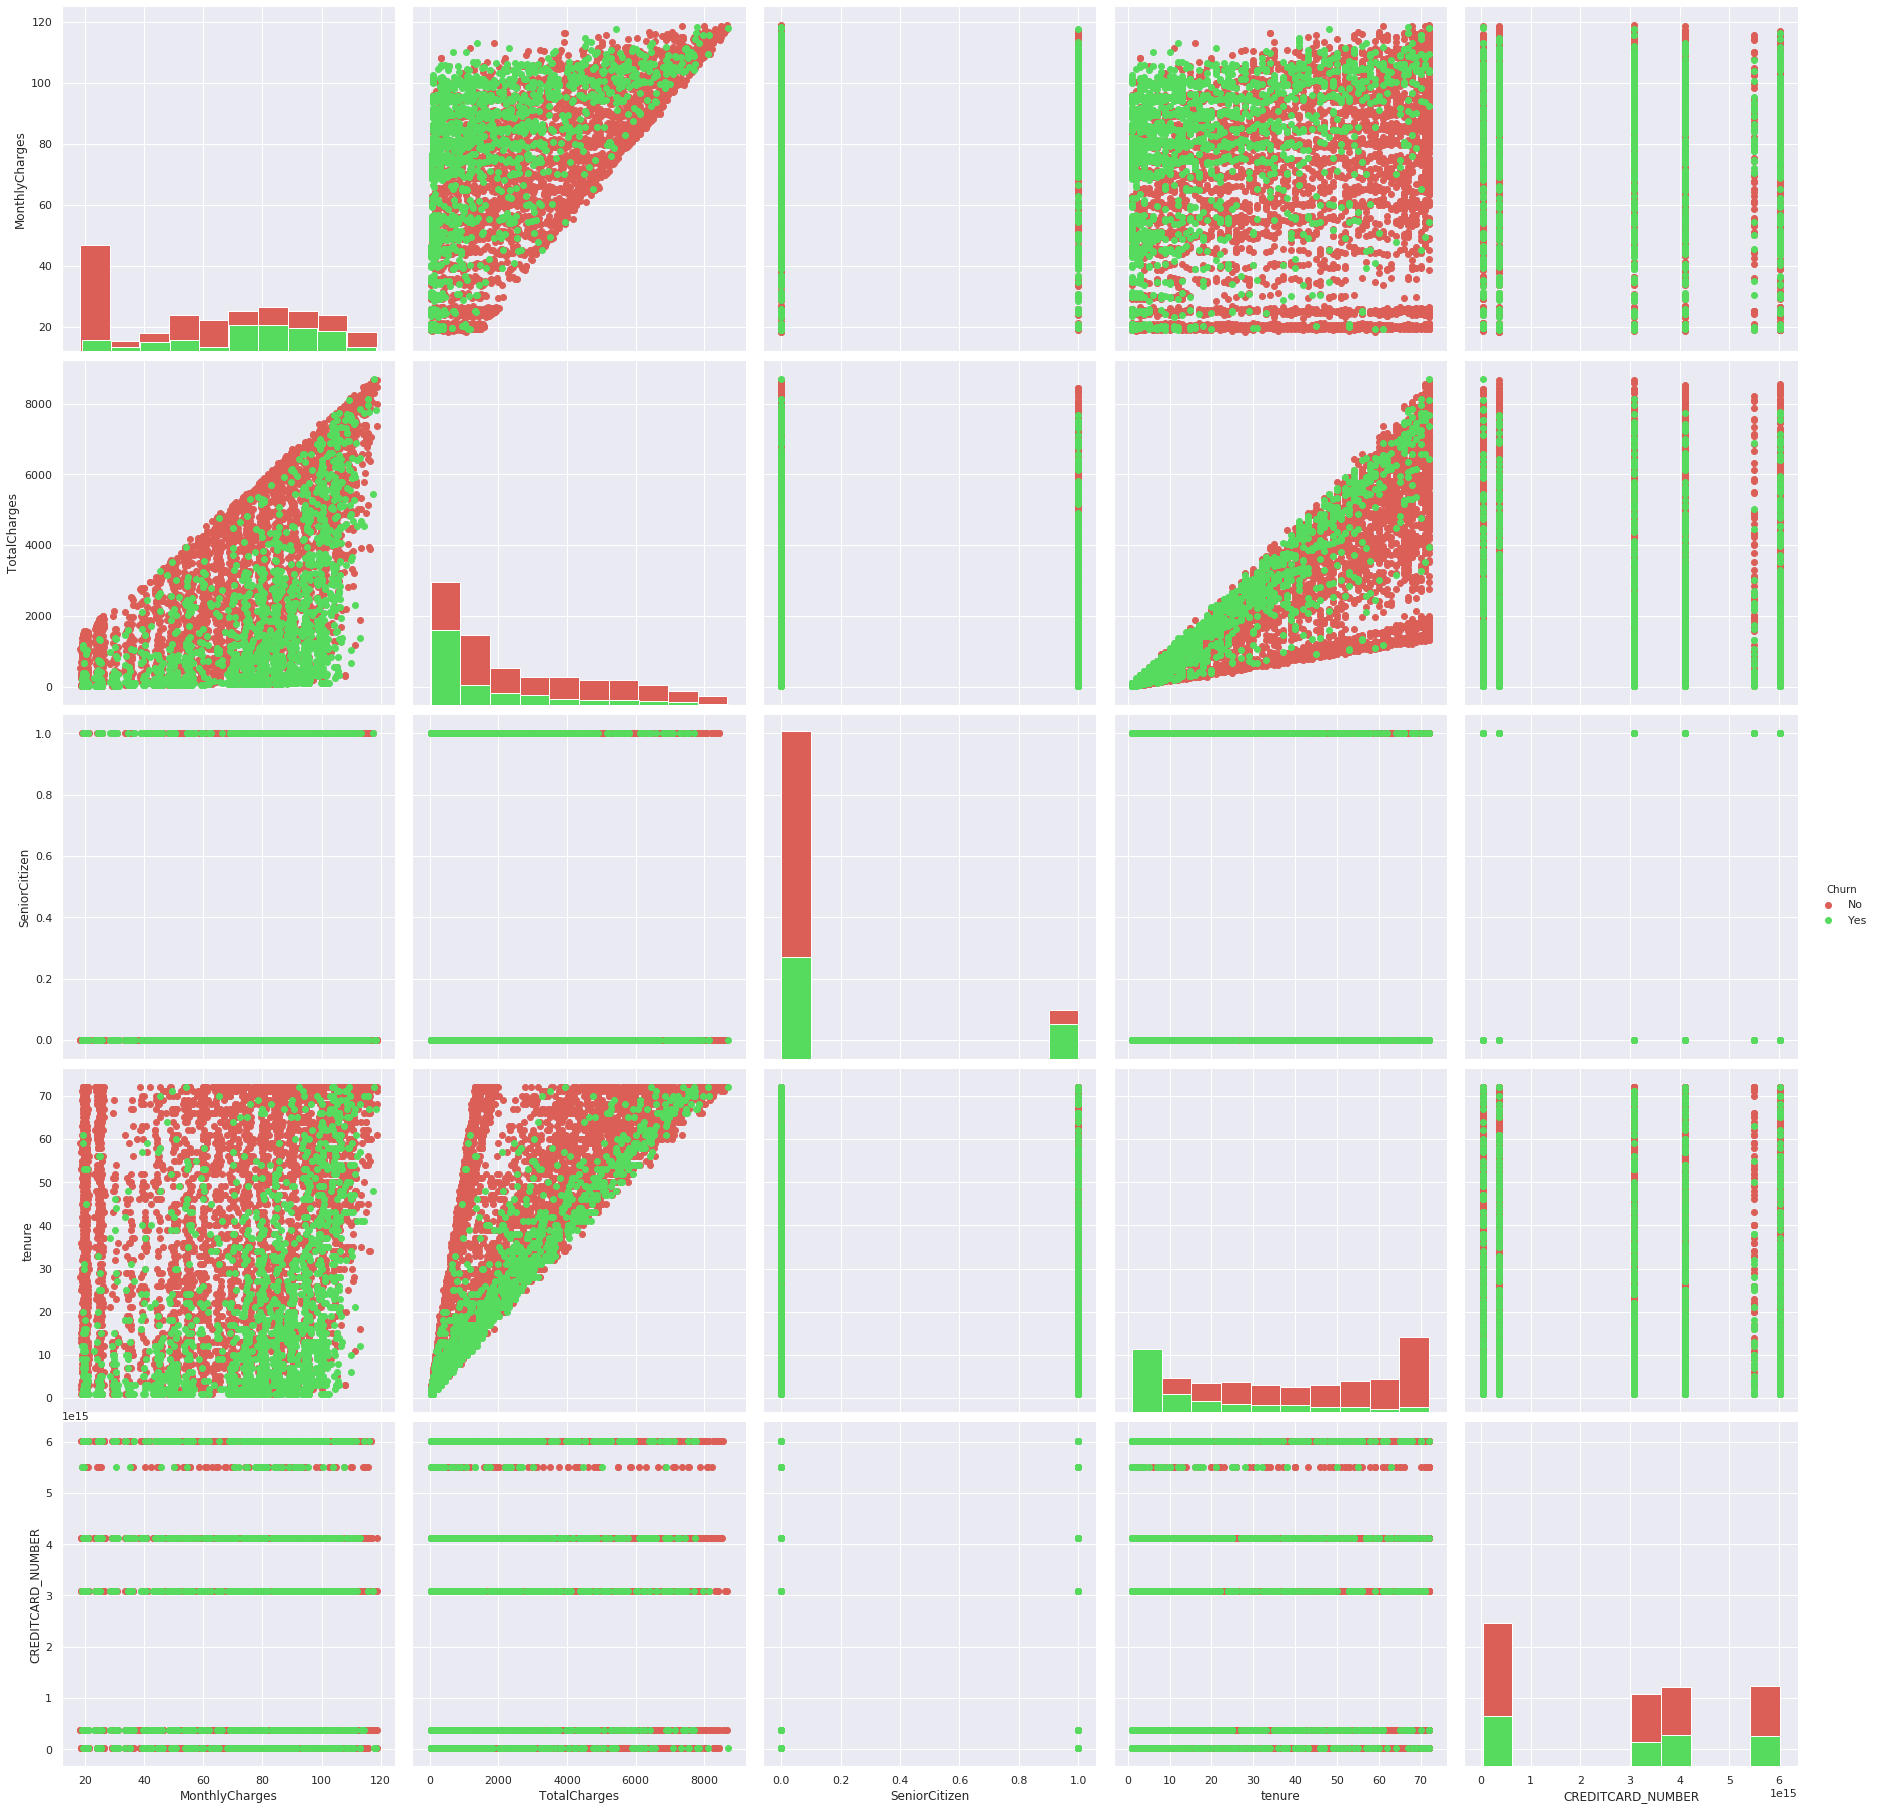

In [51]:
# Create Grid for pairwise relationships
gr = sns.PairGrid(df, height=5, hue="Churn")
gr = gr.map_diag(plt.hist)
gr = gr.map_offdiag(plt.scatter)
gr = gr.add_legend()

## 3.0 Create a model

Now we can create our machine learning model. You could use the insights / intuition gained from the data visualization steps above to what kind of model to create or which features to use. We will create a simple classification model.

In [52]:
from pyspark.sql import SparkSession
import pandas as pd
import json

spark = SparkSession.builder.getOrCreate()
df_data = spark.createDataFrame(df)
df_data.head()

Row(PhoneService='No', MultipleLines='No phone service', InternetService='DSL', OnlineSecurity='Yes', OnlineBackup='Yes', DeviceProtection='No', TechSupport='No', StreamingTV='No', StreamingMovies='No', Contract='Month-to-month', PaperlessBilling='Yes', PaymentMethod='Credit card (automatic)', MonthlyCharges=33.45, TotalCharges=1500.25, Churn='No', gender='Female', SeniorCitizen=1, Partner='No', Dependents='No', tenure=43, NATIONAL_ID='730-57-4435', CREDITCARD_NUMBER=6011470000003320, CREDITCARD_TYPE='Discover', CREDITCARD_EXP='20-Oct')

### 3.1 Split the data into training and test sets

In [53]:
spark_df = df_data
(train_data, test_data) = spark_df.randomSplit([0.8, 0.2], 24)

print("Number of records for training: " + str(train_data.count()))
print("Number of records for evaluation: " + str(test_data.count()))

Number of records for training: 5653
Number of records for evaluation: 1379


### 3.2 Examine the Spark DataFrame Schema
Look at the data types to determine requirements for feature engineering

In [54]:
spark_df.printSchema()

root
 |-- PhoneService: string (nullable = true)
 |-- MultipleLines: string (nullable = true)
 |-- InternetService: string (nullable = true)
 |-- OnlineSecurity: string (nullable = true)
 |-- OnlineBackup: string (nullable = true)
 |-- DeviceProtection: string (nullable = true)
 |-- TechSupport: string (nullable = true)
 |-- StreamingTV: string (nullable = true)
 |-- StreamingMovies: string (nullable = true)
 |-- Contract: string (nullable = true)
 |-- PaperlessBilling: string (nullable = true)
 |-- PaymentMethod: string (nullable = true)
 |-- MonthlyCharges: double (nullable = true)
 |-- TotalCharges: double (nullable = true)
 |-- Churn: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- SeniorCitizen: long (nullable = true)
 |-- Partner: string (nullable = true)
 |-- Dependents: string (nullable = true)
 |-- tenure: long (nullable = true)
 |-- NATIONAL_ID: string (nullable = true)
 |-- CREDITCARD_NUMBER: long (nullable = true)
 |-- CREDITCARD_TYPE: string (nullable =

### 3.3 Use StringIndexer to encode a string column of labels to a column of label indices

We are using the Pipeline package to build the development steps as pipeline. 
We are using StringIndexer to handle categorical / string features from the dataset. StringIndexer encodes a string column of labels to a column of label indices

We then use VectorAssembler to asemble these features into a vector. Pipelines API requires that input variables are passed in  a vector

In [55]:
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.feature import StringIndexer, IndexToString, VectorAssembler
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml import Pipeline, Model


si_gender = StringIndexer(inputCol = 'gender', outputCol = 'gender_IX')
si_Partner = StringIndexer(inputCol = 'Partner', outputCol = 'Partner_IX')
si_Dependents = StringIndexer(inputCol = 'Dependents', outputCol = 'Dependents_IX')
si_PhoneService = StringIndexer(inputCol = 'PhoneService', outputCol = 'PhoneService_IX')
si_MultipleLines = StringIndexer(inputCol = 'MultipleLines', outputCol = 'MultipleLines_IX')
si_InternetService = StringIndexer(inputCol = 'InternetService', outputCol = 'InternetService_IX')
si_OnlineSecurity = StringIndexer(inputCol = 'OnlineSecurity', outputCol = 'OnlineSecurity_IX')
si_OnlineBackup = StringIndexer(inputCol = 'OnlineBackup', outputCol = 'OnlineBackup_IX')
si_DeviceProtection = StringIndexer(inputCol = 'DeviceProtection', outputCol = 'DeviceProtection_IX')
si_TechSupport = StringIndexer(inputCol = 'TechSupport', outputCol = 'TechSupport_IX')
si_StreamingTV = StringIndexer(inputCol = 'StreamingTV', outputCol = 'StreamingTV_IX')
si_StreamingMovies = StringIndexer(inputCol = 'StreamingMovies', outputCol = 'StreamingMovies_IX')
si_Contract = StringIndexer(inputCol = 'Contract', outputCol = 'Contract_IX')
si_PaperlessBilling = StringIndexer(inputCol = 'PaperlessBilling', outputCol = 'PaperlessBilling_IX')
si_PaymentMethod = StringIndexer(inputCol = 'PaymentMethod', outputCol = 'PaymentMethod_IX')


In [56]:
si_Label = StringIndexer(inputCol="Churn", outputCol="label").fit(spark_df)
label_converter = IndexToString(inputCol="prediction", outputCol="predictedLabel", labels=si_Label.labels)

### 3.4 Create a single vector

In [57]:
va_features = VectorAssembler(inputCols=['gender_IX',  'SeniorCitizen', 'Partner_IX', 'Dependents_IX', 'PhoneService_IX', 'MultipleLines_IX', 'InternetService_IX', \
                                         'OnlineSecurity_IX', 'OnlineBackup_IX', 'DeviceProtection_IX', 'TechSupport_IX', 'StreamingTV_IX', 'StreamingMovies_IX', \
                                         'Contract_IX', 'PaperlessBilling_IX', 'PaymentMethod_IX', 'TotalCharges', 'MonthlyCharges'], outputCol="features")

### 3.5 Create a pipeline, and fit a model using RandomForestClassifier 
Assemble all the stages into a pipeline. We don't expect a clean linear regression, so we'll use RandomForestClassifier to find the best decision tree for the data.

In [58]:
classifier = RandomForestClassifier(featuresCol="features")

pipeline = Pipeline(stages=[si_gender, si_Partner, si_Dependents, si_PhoneService, si_MultipleLines, si_InternetService, si_OnlineSecurity, si_OnlineBackup, si_DeviceProtection, \
                            si_TechSupport, si_StreamingTV, si_StreamingMovies, si_Contract, si_PaperlessBilling, si_PaymentMethod, si_Label, va_features, \
                            classifier, label_converter])

model = pipeline.fit(train_data)

In [59]:
predictions = model.transform(test_data)
evaluatorDT = BinaryClassificationEvaluator(rawPredictionCol="prediction")
area_under_curve = evaluatorDT.evaluate(predictions)

evaluatorDT = BinaryClassificationEvaluator(rawPredictionCol="prediction",  metricName='areaUnderROC')
area_under_curve = evaluatorDT.evaluate(predictions)
evaluatorDT = BinaryClassificationEvaluator(rawPredictionCol="prediction",  metricName='areaUnderPR')
area_under_PR = evaluatorDT.evaluate(predictions)
print("areaUnderROC = %g" % area_under_curve)

areaUnderROC = 0.691738


## 4.0 Save the model and test data

### 4.1 Configuration

Steps to complete before running the below cell:

1. Right Click on the project name in the upper left section of the screen
2. Click on the tab where the project is opened
3. Click on Settings tab
4. Click on `Associate a deployment Space`
5. Enter `telco_churn_deployment_space_srs` in the deployment space name
6. Click on `Associate` to associate the `telco_churn_deployment_space_srs` deployment space to the project

Now the model can be saved for future deployment. The model will be saved using the Watson Machine Learning client, to a deployment space.

**<font color='red'> UPDATE THE VARIABLE 'MODEL_NAME' TO A UNIQUE NAME</font>**

**<font color='red'> UPDATE THE VARIABLE 'dep_name' TO THE NAME OF THE DEPLOYMENT SPACE CREATED PREVIOUSLY</font>**

In [60]:

MODEL_NAME = "telco_churn_model_srs"
DEPLOYMENT_NAME = 'telco_churn_deployment_srs'
DEPLOYMENT_SPACE_NAME = 'telco_churn_deployment_space_srs'


### 4.2 Input your WML Credentials


In [61]:
from ibm_watson_machine_learning import APIClient

WML_CREDENTIALS = {
"token": os.environ['USER_ACCESS_TOKEN'],
"instance_id" : "wml_local",
"url" : os.environ['RUNTIME_ENV_APSX_URL'],
"version": "3.5"
}


### 4.3 Setup Watson Machine Learning Client 

In [62]:
client = APIClient(WML_CREDENTIALS)

In [63]:
client.spaces.list()

------------------------------------  ---------------------------------------  ------------------------
GUID                                  NAME                                     CREATED
fca7af6c-15d3-47d1-8035-db2c9db5ed11  telco_churn_deployment_space_srs         2020-09-17T23:11:54.267Z
580243ac-6969-48d4-a75b-43b37f1ef418  Fraud_prediction_deployment_MN           2020-09-10T14:34:39.179Z
eadc4ff6-0118-4077-aeea-76c22c8b008e  fraud_deployment_space_ii                2020-09-09T16:11:49.502Z
ca519b3e-b43f-4f5f-ac71-f000197d1332  fraud_prediction_deployment_space_st     2020-09-09T16:02:30.401Z
a2cdd6f7-94bd-44cc-8cbe-9845ab2bb393  fraud_prediction_deployment_space_igorb  2020-09-09T15:54:26.195Z
d1622b5f-c31b-4e96-a7c5-ab6bcc631e74  fraud-prediction-deployment-space-sk     2020-09-09T15:45:56.122Z
53099dc4-e8ed-413a-9179-d20b0d07b972  fraud_prediction_deployment_space_srs    2020-09-09T15:45:12.435Z
181aa8b0-a5a5-4deb-9dc6-495051fdc259  fraud_prediction_deployment_space_vma    20

### Use the desired space as the `default_space`

The deployment space ID will be looked up based on the name specified above. If you do not receive a space GUID as an output to the next cell, do not proceed until you have created a deployment space.

In [64]:
# Be sure to update the name of the space with the one you want to use.
client.spaces.list()
all_spaces = client.spaces.get_details()['resources']
space_id = None
for space in all_spaces:
    if space['entity']['name'] == DEPLOYMENT_SPACE_NAME:
        space_id = space["metadata"]["guid"]
        print("\nDeployment Space GUID: ", space_id)

if space_id is None:
    print("WARNING: Your space does not exist. Create a deployment space before proceeding to the next cell.")
    #space_id = client.spaces.store(meta_props={client.spaces.ConfigurationMetaNames.NAME: space_name})["metadata"]["guid"]

------------------------------------  ---------------------------------------  ------------------------
GUID                                  NAME                                     CREATED
fca7af6c-15d3-47d1-8035-db2c9db5ed11  telco_churn_deployment_space_srs         2020-09-17T23:11:54.267Z
580243ac-6969-48d4-a75b-43b37f1ef418  Fraud_prediction_deployment_MN           2020-09-10T14:34:39.179Z
eadc4ff6-0118-4077-aeea-76c22c8b008e  fraud_deployment_space_ii                2020-09-09T16:11:49.502Z
ca519b3e-b43f-4f5f-ac71-f000197d1332  fraud_prediction_deployment_space_st     2020-09-09T16:02:30.401Z
a2cdd6f7-94bd-44cc-8cbe-9845ab2bb393  fraud_prediction_deployment_space_igorb  2020-09-09T15:54:26.195Z
d1622b5f-c31b-4e96-a7c5-ab6bcc631e74  fraud-prediction-deployment-space-sk     2020-09-09T15:45:56.122Z
53099dc4-e8ed-413a-9179-d20b0d07b972  fraud_prediction_deployment_space_srs    2020-09-09T15:45:12.435Z
181aa8b0-a5a5-4deb-9dc6-495051fdc259  fraud_prediction_deployment_space_vma    20

In [65]:
# Now set the default space to the GUID for your deployment space. If this is successful, you will see a 'SUCCESS' message.
client.set.default_space(space_id)

'SUCCESS'

### 4.4 Store the model

In [66]:
wml_models = client.repository.get_model_details()
model_uid = None

for model_in in wml_models['resources']:
    if MODEL_NAME == model_in['entity']['name']:
        model_uid = model_in['metadata']['guid']
        break

if model_uid is None:
    print("Storing model ...")
    metadata = {
        client.repository.ModelMetaNames.NAME: MODEL_NAME,
        client.repository.ModelMetaNames.TYPE: 'mllib_2.3',
        client.repository.ModelMetaNames.RUNTIME_UID: 'spark-mllib_2.3',
    }

    published_model_details = client.repository.store_model(model, metadata, training_data=df_data,  pipeline=pipeline)
    model_uid = client.repository.get_model_uid(published_model_details)
    print("Done")

Storing model ...
Done


At this point you can verify the stored model by going to the deployment space you created earlier. You will be able to see the model listed in the assets tab.

In [67]:
published_model_uid = client.repository.get_model_uid(published_model_details)

In [68]:
deployment_details = client.deployments.get_details()
for deployment in deployment_details['resources']:
    deployment_id = deployment['metadata']['guid']
    model_id = deployment['entity']['asset']['href'].split('/')[3].split('?')[0]
    if deployment['entity']['name'] == DEPLOYMENT_NAME:
        print('Deleting deployment id', deployment_id)
        client.deployments.delete(deployment_id)
        print('Deleting model id', model_id)
        client.repository.delete(model_id)
client.repository.list_models()

------------------------------------  ---------------------  ------------------------  ---------
GUID                                  NAME                   CREATED                   TYPE
990306b7-ddd2-476b-8b18-a4c378b0a70f  telco_churn_model_srs  2020-09-17T23:28:31.002Z  mllib_2.3
------------------------------------  ---------------------  ------------------------  ---------


In [69]:
model_uid

'990306b7-ddd2-476b-8b18-a4c378b0a70f'

## 5. Deploy the model <a name="deployment"></a>

In [70]:
## Create a Deployment for your stored model

wml_deployments = client.deployments.get_details()
deployment_uid = None
for deployment in wml_deployments['resources']:
    if DEPLOYMENT_NAME == deployment['entity']['name']:
        deployment_uid = deployment['metadata']['guid']
        break

if deployment_uid is None:
    print("Deploying model...")
    meta_props = {
        client.deployments.ConfigurationMetaNames.NAME: DEPLOYMENT_NAME,
        client.deployments.ConfigurationMetaNames.ONLINE: {}
    }
    deployment = client.deployments.create(artifact_uid=model_uid, meta_props=meta_props)
    deployment_uid = client.deployments.get_uid(deployment)
    
print("Model id: {}".format(model_uid))
print("Deployment id: {}".format(deployment_uid))

Deploying model...


#######################################################################################

Synchronous deployment creation for uid: '990306b7-ddd2-476b-8b18-a4c378b0a70f' started

#######################################################################################


initializing.
ready


------------------------------------------------------------------------------------------------
Successfully finished deployment creation, deployment_uid='a14e4613-2017-460c-8414-b3db90140255'
------------------------------------------------------------------------------------------------


Model id: 990306b7-ddd2-476b-8b18-a4c378b0a70f
Deployment id: a14e4613-2017-460c-8414-b3db90140255


At this point you can verify the deployed model by going to the deployment space you created earlier. You will be able to see the model deployment listed in the Deployments tab with a green tick (for the successfully deployed model)

In [71]:
telco_churn_scoring_endpoint = None
print(deployment_uid)

for deployment in client.deployments.get_details()['resources']:
    if deployment_uid in deployment['metadata']['guid']:
        telco_churn_scoring_endpoint = deployment['entity']['status']['online_url']['url']
        
print(telco_churn_scoring_endpoint)

a14e4613-2017-460c-8414-b3db90140255
https://internal-nginx-svc:12443/v4/deployments/a14e4613-2017-460c-8414-b3db90140255/predictions


## 6. Testing the deployed model <a name="testing"></a>

In [72]:
score_X = test_data.drop("Churn")
score_X = score_X.head(20)

scoring_data = []
for i in range(len(score_X)):
#     print(list(score_X[i].asDict().values()))
    scoring_data.append(list(score_X[i].asDict().values()))

fields=list(score_X[0].asDict().keys())
print(len(fields))
fields, scoring_data[0]

job_payload = {
client.deployments.ScoringMetaNames.INPUT_DATA: [{
 'fields': fields,
 'values': scoring_data
}]
}
print(json.dumps(job_payload))

23
{"input_data": [{"fields": ["PhoneService", "MultipleLines", "InternetService", "OnlineSecurity", "OnlineBackup", "DeviceProtection", "TechSupport", "StreamingTV", "StreamingMovies", "Contract", "PaperlessBilling", "PaymentMethod", "MonthlyCharges", "TotalCharges", "gender", "SeniorCitizen", "Partner", "Dependents", "tenure", "NATIONAL_ID", "CREDITCARD_NUMBER", "CREDITCARD_TYPE", "CREDITCARD_EXP"], "values": [["No", "No phone service", "DSL", "No", "No", "No", "No", "No", "No", "Month-to-month", "No", "Bank transfer (automatic)", 24.8, 24.8, "Male", 0, "No", "No", 1, "237-06-5928", 4111300000000410, "VISA", "18-Jun"], ["No", "No phone service", "DSL", "No", "No", "No", "No", "No", "No", "Month-to-month", "No", "Credit card (automatic)", 25.0, 789.2, "Male", 0, "No", "Yes", 31, "309-69-7202", 370000034957607, "American Express", "20-Nov"], ["No", "No phone service", "DSL", "No", "No", "No", "No", "No", "No", "Month-to-month", "No", "Mailed check", 24.4, 24.4, "Male", 0, "No", "No", 1

Copy this text above ^ and paste it in the Enter Input data box for testing the deployed model. The results should match the predictions shown below

In [73]:
scoring_response = client.deployments.score(deployment_uid, job_payload)

print(scoring_response)

{'predictions': [{'fields': ['PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'NATIONAL_ID', 'CREDITCARD_NUMBER', 'CREDITCARD_TYPE', 'CREDITCARD_EXP', 'gender_IX', 'Partner_IX', 'Dependents_IX', 'PhoneService_IX', 'MultipleLines_IX', 'InternetService_IX', 'OnlineSecurity_IX', 'OnlineBackup_IX', 'DeviceProtection_IX', 'TechSupport_IX', 'StreamingTV_IX', 'StreamingMovies_IX', 'Contract_IX', 'PaperlessBilling_IX', 'PaymentMethod_IX', 'label', 'features', 'rawPrediction', 'probability', 'prediction', 'predictedLabel'], 'values': [['No', 'No phone service', 'DSL', 'No', 'No', 'No', 'No', 'No', 'No', 'Month-to-month', 'No', 'Bank transfer (automatic)', 24.8, 24.8, 'Male', 0, 'No', 'No', 1, '237-06-5928', 4111300000000410, 'VISA', '18-Jun', 0.0, 

In [74]:
scoring_response = client.deployments.score(deployment_uid, job_payload)

print('Single record scoring result:', '\n fields:', scoring_response['predictions'][0]['fields'], '\n values: ', scoring_response['predictions'][0]['values'][0])

Single record scoring result: 
 fields: ['PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'NATIONAL_ID', 'CREDITCARD_NUMBER', 'CREDITCARD_TYPE', 'CREDITCARD_EXP', 'gender_IX', 'Partner_IX', 'Dependents_IX', 'PhoneService_IX', 'MultipleLines_IX', 'InternetService_IX', 'OnlineSecurity_IX', 'OnlineBackup_IX', 'DeviceProtection_IX', 'TechSupport_IX', 'StreamingTV_IX', 'StreamingMovies_IX', 'Contract_IX', 'PaperlessBilling_IX', 'PaymentMethod_IX', 'label', 'features', 'rawPrediction', 'probability', 'prediction', 'predictedLabel'] 
 values:  ['No', 'No phone service', 'DSL', 'No', 'No', 'No', 'No', 'No', 'No', 'Month-to-month', 'No', 'Bank transfer (automatic)', 24.8, 24.8, 'Male', 0, 'No', 'No', 1, '237-06-5928', 4111300000000410, 'VISA', '18-

## Congratulations!

You have finished running the notebook for training, creating and deploying Telco Churn prediction model. You can now view the deployed model by going to the Project and selecting the `Settings` tab. Choose the `Associated deployment space` that you have created and click to `Open`. Select `Deployments` tab and click on your deployment to open it. Click on the test tab for the deployment you've created to test the model.